In [1981]:
from google.colab import files
uploaded = files.upload()

In [1982]:
import pandas as pd
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

In [1983]:
# Load the data
data = pd.read_csv("/content/clean_kaggle_data_2022.csv", encoding='ISO-8859-1')

# Display the first few rows of the dataset to understand its structure
data.head()

/Applications/Anaconda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q10_1,Q10_2,Q10_3,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,...,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, university, or graduate)",On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,On which platforms have you begun or completed data science courses? (Select all that apply) - S...,What products or platforms did you find to be most helpful when you first started studying data ...,What products or platforms did you find to be most helpful when you first started studying data ...,What products or platforms did you find to be most helpful when you first started studying data ...,What products or platforms did you find to be most helpful when you first started studying data ...,What products or platforms did you find to be most helpful when you first started studying data ...,What products or platforms did you find to be most helpful when you first started studying data ...,What products or platforms did you find to be most helpful when you first started studying data ...,What is the highest level of formal education that you have attained or plan to attain within th...,"Have you ever published any academic research (papers, preprints, conference proceedings, etc)?","Did your research make use of machine learning? - Yes, the research made advances related to som...","Did your research make use of machine learning? - Yes, the research made use of machine learning...",Did your research make use of machine learning? - No,For how many years have you been writing code and/or programming?,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Select all that apply) - Selected Cho...,What programming languages do you use on a regular basis? (Selec

## Identify Missing Value

In [1984]:
# Identify missing values
missing_values_count = data.isnull().sum()

# Get the percentage of missing values for each column
missing_values_percentage = (missing_values_count / len(data)) * 100

# Display the missing values count and percentage
missing_values_summary = pd.DataFrame({
    'Data Type': data.dtypes,
    'count': missing_values_count,
    'Unique Values': data.nunique(),
    'percentage': missing_values_percentage
})

missing_values_summary.sort_values(by='percentage', ascending=False)

,Data Type,count,Unique Values,percentage
Q40_8,object,8114,2,99.717341
Q36_13,object,8114,2,99.717341
Q14_10,object,8114,2,99.717341
Q42_5,object,8110,2,99.668182
Q37_9,object,8107,2,99.631314
...,...,...,...,...
Q8,object,0,8,0.000000
Q5,object,0,2,0.000000
Q4,object,0,59,0.000000
Q3,object,0,6,0.000000


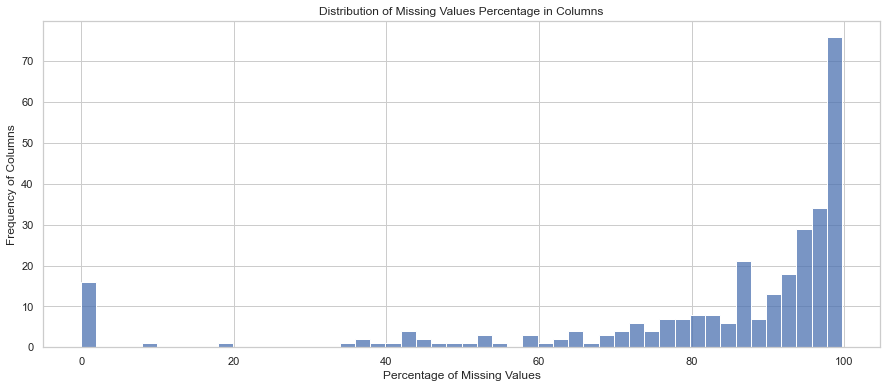

In [1985]:
# Visualize the distribution of missing values

plt.figure(figsize=(15, 6))
sns.histplot(missing_values_percentage, bins=50, kde=False)
plt.title('Distribution of Missing Values Percentage in Columns')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency of Columns')
plt.show()

## replace missing value with "No Selection" for Multiple-Choice, Categorical, Numerical Columns

In [1986]:
# Remove the first row which contains non-data header information
data_cleaned = data.iloc[1:]
# Reset the index
data_cleaned.reset_index(drop=True, inplace=True)

# Let's first check the columns to identify the multiple-choice questions.
# These questions usually follow a naming convention like Q#_Part#, e.g., Q1_Part1, Q1_Part2, etc.
# We will look for columns that have a similar pattern and then treat missing values as 'No Selection'.

# Identify columns that are likely to be part of a multiple-choice question
multichoice_columns = [col for col in data.columns if '_' in col and 'OTHER' not in col]

# Fill missing values for these columns with 'No Selection'
for col in multichoice_columns:
    data[col].fillna('No Selection', inplace=True)

# Let's verify that the missing values have been handled for these multiple-choice columns
missing_values_multichoice_columns = data[multichoice_columns].isnull().sum().sum()

missing_values_multichoice_columns, data[multichoice_columns].head(10)


(0,
                                                                                                   Q6_1  \
 0  On which platforms have you begun or completed data science courses? (Select all that apply) - S...   
 1                                                                                             Coursera   
 2                                                                                             Coursera   
 3                                                                                             Coursera   
 4                                                                                             Coursera   
 5                                                                                             Coursera   
 6                                                                                             Coursera   
 7                                                                                         No Selection   
 8                               

In [1987]:
# For other categorical columns, fill missing values with 'Unknown'
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna('Unknown')

# For numerical columns, fill missing values with the median
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Check if there are any missing values left
missing_values_categorical_cols = data[categorical_cols].isnull().sum().sum()
missing_values_numerical_cols = data[numerical_cols].isnull().sum().sum()

print(missing_values_categorical_cols, data[categorical_cols].head(10))
missing_values_numerical_cols, data[numerical_cols].head(10)



0    Duration (in seconds)                           Q2  \
0  Duration (in seconds)  What is your age (# years)?   
1                    851                        55-59   
2                    501                        30-34   
3                    787                          70+   
4                   1132                        40-44   
5                    679                        40-44   
6                  10619                        30-34   
7                    587                        50-54   
8                    676                        25-29   
9                    542                        30-34   

                                       Q3  \
0  What is your gender? - Selected Choice   
1                                     Man   
2                                     Man   
3                                     Man   
4                                     Man   
5                                     Man   
6                                     Man   
7         

(0.0,
 Empty DataFrame
 Columns: []
 Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Check again for missing value

In [1988]:
# Identify missing values
missing_values_count = data.isnull().sum()

# Get the percentage of missing values for each column
missing_values_percentage = (missing_values_count / len(data)) * 100

# Display the missing values count and percentage
missing_values_summary = pd.DataFrame({
    'Data Type': data.dtypes,
    'count': missing_values_count,
    'Unique Values': data.nunique(),
    'percentage': missing_values_percentage
})

print(missing_values_summary.sort_values(by='percentage', ascending=False))
print(missing_values_summary.describe())

                      Data Type  count  Unique Values  percentage
Duration (in seconds)    object      0           3104         0.0
Q36_3                    object      0              3         0.0
Q36_1                    object      0              3         0.0
Q35_16                   object      0              3         0.0
Q35_15                   object      0              3         0.0
...                         ...    ...            ...         ...
Q17_9                    object      0              3         0.0
Q17_8                    object      0              3         0.0
Q17_7                    object      0              3         0.0
Q17_6                    object      0              3         0.0
Q29_buckets              object      0             16         0.0

[298 rows x 4 columns]
       count  Unique Values  percentage
count  298.0     298.000000       298.0
mean     0.0      14.080537         0.0
std      0.0     179.641113         0.0
min      0.0       2.000

## Identify the unique values

In [1989]:
# First, we need to identify potential ordinal columns. We'll do this by inspecting unique values in each categorical column.
# Since there are many columns, we'll only print out the unique values for columns with less than a certain number of unique values to keep it manageable.
# Let's look at columns with 10 or fewer unique values as a starting point.

# Select categorical columns with fewer unique values for inspection
categorical_cols_to_inspect = data[categorical_cols].nunique()[data[categorical_cols].nunique() <= 10].index

# Display unique values for these columns
unique_values_in_categorical_cols = {col: data[col].unique() for col in categorical_cols_to_inspect}

unique_values_in_categorical_cols

{'Q3': array(['What is your gender? - Selected Choice', 'Man', 'Woman',
        'Prefer not to say', 'Prefer to self-describe', 'Nonbinary'],
       dtype=object),
 'Q5': array(['Are you currently a student? (high school, university, or graduate)',
        'No'], dtype=object),
 'Q6_1': array(['On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Coursera',
        'Coursera', 'No Selection'], dtype=object),
 'Q6_2': array(['On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - edX',
        'No Selection', 'edX'], dtype=object),
 'Q6_3': array(['On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Kaggle Learn Courses',
        'Kaggle Learn Courses', 'No Selection'], dtype=object),
 'Q6_4': array(['On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice 

In [1990]:
# Identify potential ordinal features by focusing on features with fewer unique categories
potential_ordinal_features = data.nunique().sort_values().head(10)
potential_ordinal_features

Q5       2
Q44_8    3
Q35_7    3
Q35_6    3
Q35_5    3
Q35_4    3
Q35_3    3
Q35_2    3
Q35_1    3
Q34_8    3
dtype: int64

In [1991]:
# Filter out features with more than two unique values to inspect for ordinality
potential_ordinal_features = potential_ordinal_features[potential_ordinal_features > 2]

# Display the unique values for these features
ordinal_values = {}
for feature in potential_ordinal_features.index:
    ordinal_values[feature] = data_cleaned[feature].unique()

ordinal_values

{'Q44_8': array(['Blogs (Towards Data Science, Analytics Vidhya, etc)',
        'No Selection'], dtype=object),
 'Q35_7': array(['No Selection', 'IBM Db2 '], dtype=object),
 'Q35_6': array(['No Selection', 'Snowflake '], dtype=object),
 'Q35_5': array(['MongoDB ', 'No Selection'], dtype=object),
 'Q35_4': array(['No Selection', 'Oracle Database '], dtype=object),
 'Q35_3': array(['No Selection', 'SQLite '], dtype=object),
 'Q35_2': array(['No Selection', 'PostgreSQL '], dtype=object),
 'Q35_1': array(['No Selection', 'MySQL '], dtype=object),
 'Q34_8': array(['No Selection', 'Other'], dtype=object)}

## There are garbage text in Q8 in dataset which affects Encoding

In [1992]:
# Assuming the garbage characters are non-ASCII, this regex will match any non-ASCII character
garbage_regex = r'[^\x00-\x7F]+'

# Replace the garbage characters with an empty string or the correct abbreviation for "Master's degree" or "Bachelor's degree"
data['Q8'] = data['Q8'].str.replace(garbage_regex, "'", regex=True)
data['Q8'] = data['Q8'].str.replace("'E'Es", "'s", regex=False)

# Now inspect the cleaned column to verify the replacement
data['Q8'].unique()


array(['What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
       "Some college/university study without earning a bachelor's degree",
       "Bachelor's degree", 'Doctoral degree', "Master's degree",
       'I prefer not to answer', 'No formal education past high school',
       'Professional doctorate'], dtype=object)

## Encoding

In [1993]:
# Let's create a mapping for ordinal encoding of the education level (Q8)
education_mapping = {
    'No formal education past high school': 0,
    'Some college/university study without earning a bachelor’s degree': 1,
    'Bachelor\'s degree': 2,
    'Master\'s degree': 3,
    'Doctoral degree': 4,
    'Professional doctorate': 5,
    'I prefer not to answer': None # We'll treat this as a missing value
}

# Apply ordinal encoding to the 'Q8' column
data['Q8'] = data['Q8'].map(education_mapping).fillna(0)

# Similarly, let's create a mapping for the years of coding experience (Q11)
experience_mapping = {
    'I have never written code': 0,
    '< 1 years': 1,
    '1-3 years': 2,
    '3-5 years': 3,
    '5-10 years': 4,
    '10-20 years': 5,
    '20+ years': 6
}

# Apply ordinal encoding to the 'Q11' column
data['Q11'] = data['Q11'].map(experience_mapping).fillna(0)

# Now let's check the result of these operations
data[['Q8', 'Q11']].head(10)


,Q8,Q11
0,0.0,0.0
1,0.0,5.0
2,2.0,5.0
3,4.0,6.0
4,4.0,5.0
5,3.0,5.0
6,3.0,4.0
7,4.0,3.0
8,3.0,4.0
9,0.0,1.0


## Discover Ordinal Encoding

In [1994]:
# Remove the first row which contains the questions instead of respondent data
data = data.iloc[1:]

# Retrieve the categorical columns again since we've made changes to the data
categorical_cols = data.select_dtypes(include=['object']).columns

# We'll assume that any column with more than 10 unique values is nominal
nominal_cols = [col for col in categorical_cols if data[col].nunique() > 10]

# The remaining categorical columns will be considered for ordinal encoding
potential_ordinal_cols = list(set(categorical_cols) - set(nominal_cols))

# Let's print out the unique values for these columns to decide on the encoding strategy
unique_values_potential_ordinal = {col: data[col].unique() for col in potential_ordinal_cols}
unique_values_potential_ordinal


{'Q14_15': array(['No Selection', 'None'], dtype=object),
 'Q42_2': array(['No Selection', ' TPUs '], dtype=object),
 'Q20_3': array(['No Selection', 'Contextualized embeddings (ELMo, CoVe)'],
       dtype=object),
 'Q17_11': array(['No Selection', ' JAX '], dtype=object),
 'Q40_5': array(['No Selection', ' Guild.ai '], dtype=object),
 'Q33_2': array(['No Selection', ' Microsoft Azure Virtual Machines '], dtype=object),
 'Q10_1': array(['No Selection',
        'Yes, the research made advances related to some novel machine learning method (theoretical research)'],
       dtype=object),
 'Q33_5': array(['No Selection', 'Other'], dtype=object),
 'Q39_2': array(['No Selection', ' TorchServe '], dtype=object),
 'Q39_12': array(['No Selection', 'Other'], dtype=object),
 'Q12_7': array(['No Selection', 'Java'], dtype=object),
 'Q36_9': array(['No Selection', 'Alteryx '], dtype=object),
 'Q36_4': array(['No Selection', 'Looker'], dtype=object),
 'Q15_6': array(['No Selection', ' D3 js '], dtyp

In [1995]:
# Encoding the binary response columns
binary_response_cols = [col for col in potential_ordinal_cols if data[col].nunique() == 2]

# Replace NaN with 0 (option not selected) and the specific option name with 1 (option selected)
for col in binary_response_cols:
    data[col] = data[col].notnull().astype(int)

# Now let's inspect the columns with more than two unique values
columns_to_inspect = ['Q16', 'Q30', 'Q26']
columns_unique_values = {col: data[col].unique() for col in columns_to_inspect}
columns_unique_values

{'Q16': array(['1-2 years', '4-5 years', '5-10 years', '2-3 years',
        'Under 1 year', '3-4 years', '10-20 years',
        'I do not use machine learning methods', 'Unknown'], dtype=object),
 'Q30': array(['$1000-$9,999', '$0 ($USD)', '$100-$999',
        '$100,000 or more ($USD)', '$1-$99', '$10,000-$99,999', 'Unknown'],
       dtype=object),
 'Q26': array(['2-Jan', '20+', '4-Mar', '9-May', '0', '14-Oct', '15-19'],
       dtype=object)}

In [1996]:
# Define the ordinal mappings for Q16, Q30, and Q26
ml_experience_mapping = {
    'Under 1 year': 0,
    '1-2 years': 1,
    '2-3 years': 2,
    '3-4 years': 3,
    '4-5 years': 4,
    '5-10 years': 5,
    '10-20 years': 6,
    'I do not use machine learning methods': -1
}
ml_spending_mapping = {
    '$0 ($USD)': 0,
    '$1-$99': 1,
    '$100-$999': 2,
    '$1000-$9,999': 3,
    '$10,000-$99,999': 4,
    '$100,000 or more ($USD)': 5
}
data_science_team_size_mapping = {
    '0': 0,
    '1-2': 1,
    '3-4': 2,
    '5-9': 3,
    '10-14': 4,
    '15-19': 5,
    '20+': 6
}

# Correct typographical errors in Q26
data['Q26_Corrected'] = data['Q26'].replace({
    '2-Jan': '1-2',
    '3-Mar': '3-4',
    '4-Mar': '3-4',  # Assuming '4-Mar' is a typo for '3-4'
    '9-May': '5-9',
    '14-Oct': '10-14'  # Assuming '14-Oct' is a typo for '10-14'
})
# Encode Q2 with ordinal encoding
age_mapping = {
    '18-21': 0, '22-24': 1, '25-29': 2, '30-34': 3, '35-39': 4,
    '40-44': 5, '45-49': 6, '50-54': 7, '55-59': 8, '60-69': 9, '70+': 10
}
data['Q2'] = data['Q2'].map(age_mapping)

# Encode Q5 as binary
student_mapping = {'No': 0}
data['Q5'] = data['Q5'].map(student_mapping).fillna(1)  # Assuming NaN as "Yes"

# Encode Q9 as binary, treating NaN as "No"
data['Q9'] = data['Q9'].map({'No': 0, 'Yes': 1}).fillna(0)

# Fill NaN values with a placeholder string 'Missing' for Q43
data['Q43'] = data['Q43'].fillna('Missing')

# Define the mapping for Q43 including the 'Missing' category
q43_mapping = {
    'Never': 0,
    'Once': 1,
    '2-5 times': 2,
    '6-25 times': 3,
    'More than 25 times': 4,
    'Missing': 5  # Mapping 'Missing' as another category
}

# Apply the mapping to the column
data['Q43'] = data['Q43'].map(q43_mapping).fillna(0)


# Mappings for ordinal encoding
company_size_mapping = {
    '0-49 employees': 0,
    '50-249 employees': 1,
    '250-999 employees': 2,
    '1000-9,999 employees': 3,
    '10,000 or more employees': 4
}

ml_methods_mapping = {
    'No (we do not use ML methods)': 0,
    'We are exploring ML methods (and may one day put a model into production)': 1,
    'We recently started using ML methods (i.e., models in production for less than 2 years)': 2,
    'We have well established ML methods (i.e., models in production for more than 2 years)': 3,
    'We use ML methods for generating insights (but do not put working models into production)': 4,
    'I do not know': -1  # Treating "I do not know" as a missing value
}

# Apply ordinal encoding to Q25 and Q27
data['Q25'] = data['Q25'].map(company_size_mapping)
data['Q27'] = data['Q27'].map(ml_methods_mapping)

data['Duration (in seconds)'] = pd.to_numeric(data['Duration (in seconds)'], errors='coerce')


# Applying one-hot encoding
q22_encoded = pd.get_dummies(data['Q22'], prefix='Q22')
q23_encoded = pd.get_dummies(data['Q23'], prefix='Q23')
q24_encoded = pd.get_dummies(data['Q24'], prefix='Q24')
q32_encoded = pd.get_dummies(data['Q32'], prefix='Q32')

# Drop the original columns from the dataframe
data.drop(['Q22', 'Q23', 'Q24', 'Q32'], axis=1, inplace=True)

# Concatenate the new one-hot encoded columns to the dataframe
data = pd.concat([data, q22_encoded, q23_encoded, q24_encoded, q32_encoded], axis=1)


# Apply label encoding for Q3 while maintaining it in the same column
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'Q3' column with label encoding
data['Q3'] = label_encoder.fit_transform(data['Q3'])
# Apply the mappings to the columns
data['Q16'] = data['Q16'].map(ml_experience_mapping).fillna(-2)
data['Q30'] = data['Q30'].map(ml_spending_mapping).fillna(-1)
data['Q26'] = data['Q26_Corrected'].map(data_science_team_size_mapping).fillna(-1)
data['Q29'] = data['Q29_Encoded']

# Convert '[Q29]' to a numeric type explicitly
data['Q29'] = pd.to_numeric(data['Q29'], errors='coerce')


/var/folders/q3/0rjm6gb921s0ghz13gkws7kw0000gn/T/ipykernel_89266/1569056993.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Q26_Corrected'] = data['Q26'].replace({


## Drop Unecessary data

In [1997]:
# Drop the 'Q4' and 'Duration (in seconds)' columns from the dataset since they are not needed for the analysis
data.drop(['Q4','Q29_Encoded'], axis=1, inplace=True)

In [1998]:
data

,Duration (in seconds),Q2,Q3,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q10_1,Q10_2,Q10_3,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,...,Q22_ Kaggle datasets,Q22_ NVIDIA NGC models,Q22_ ONNX models,Q22_ PyTorch Hub,Q22_ Timm,Q22_Other storage services (i.e. google drive),Q22_Unknown,Q23_Data Administrator,"Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)",Q23_Data Architect,Q23_Data Engineer,Q23_Data Scientist,Q23_Developer Advocate,Q23_Engineer (non-software),Q23_Machine Learning/ MLops Engineer,"Q23_Manager (Program, Project, Operations, Executive-level, etc)",Q23_Other,Q23_Research Scientist,Q23_Software Engineer,Q23_Statistician,Q23_Teacher / professor,Q24_Academics/Education,Q24_Accounting/Finance,Q24_Broadcasting/Communications,Q24_Computers/Technology,Q24_Energy/Mining,Q24_Government/Public Service,Q24_Insurance/Risk Assessment,Q24_Manufacturing/Fabrication,Q24_Marketing/CRM,Q24_Medical/Pharmaceutical,Q24_Non-profit/Service,Q24_Online Service/Internet-based Services,Q24_Other,Q24_Retail/Sales,Q24_Shipping/Transportation,Q32_ Alibaba Cloud,Q32_ Amazon Web Services (AWS),Q32_ Google Cloud Platform (GCP),Q32_ Huawei Cloud,Q32_ IBM Cloud / Red Hat,Q32_ Microsoft Azure,Q32_ Oracle Cloud,Q32_ SAP Cloud,Q32_ Tencent Cloud,Q32_ VMware Cloud,Q32_None were satisfactory,Q32_Other,Q32_They all had a similarly enjoyable developer experience,Q32_Unknown
1,851,8,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,0.0,1,1,1,5.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,501,3,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2.0,0.0,1,1,1,5.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,787,10,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4.0,1.0,1,1,1,6.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1132,5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4.0,1.0,1,1,1,5.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,679,5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3.0,1.0,1,1,1,5.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8132,540,5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3.0,0.0,1,1,1,5.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8133,603,4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3.0,0.0,1,1,1,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8134,557,5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2.0,0.0,1,1,1,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8135,860,2,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3.0,1.0,1,1,1,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Data Exploratory and Feature Selection

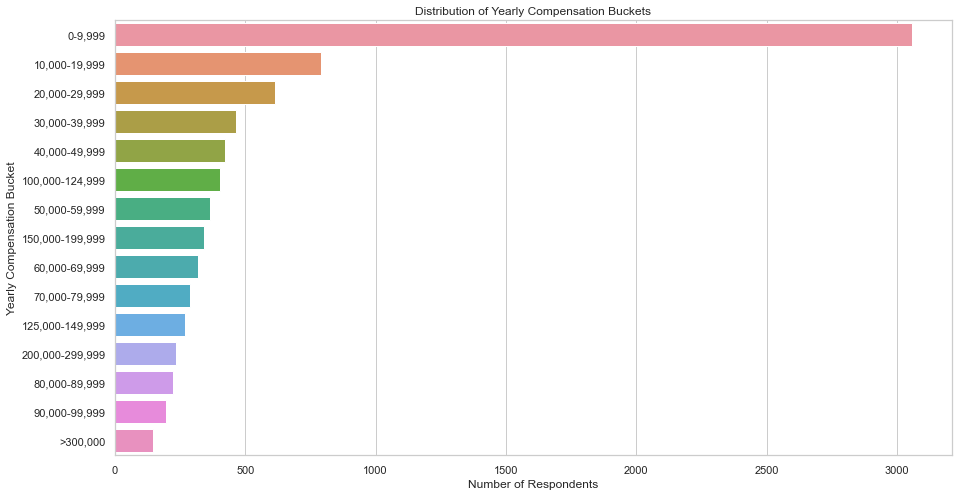

In [1999]:
# Setting up the style for plots
sns.set_style("whitegrid")

# Plotting the distribution of the target variable: Q29_buckets
plt.figure(figsize=(15, 8))
sns.countplot(y=data['Q29_buckets'], order=data['Q29_buckets'].value_counts().index)
plt.title('Distribution of Yearly Compensation Buckets')
plt.xlabel('Number of Respondents')
plt.ylabel('Yearly Compensation Bucket')
plt.show()

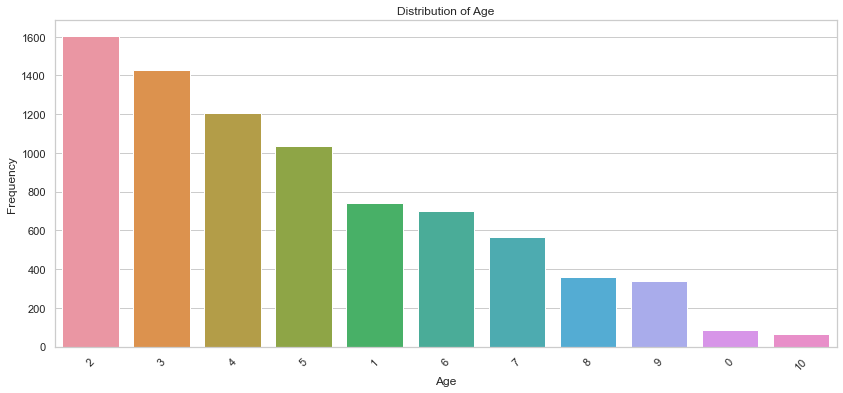

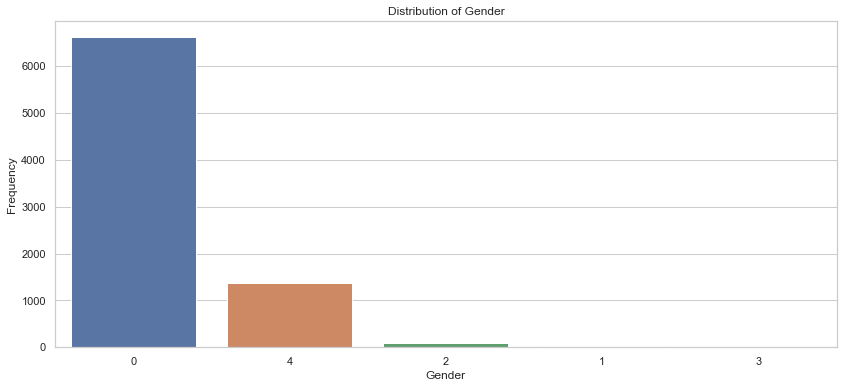

In [2000]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the distribution of age (Q2)
plt.figure(figsize=(14, 6))
sns.countplot(data=data, x='Q2', order = data['Q2'].value_counts().index)
plt.title('Distribution of Age')
plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of gender (Q3)
plt.figure(figsize=(14, 6))
sns.countplot(data=data, x='Q3', order = data['Q3'].value_counts().index)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()


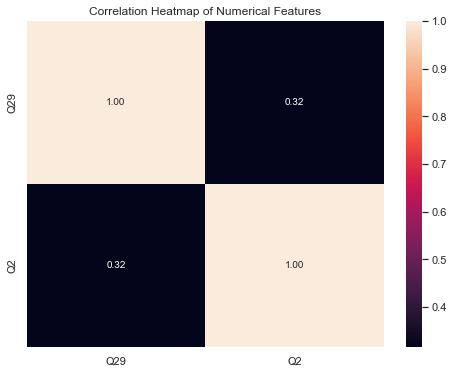

In [2001]:
# Correlation heatmap for the numerical features
# For the sake of demonstration, let's assume 'Age' and 'YearsExperience' are the only numerical features we have
plt.figure(figsize=(8, 6))
sns.heatmap(data[['Q29', 'Q2']].corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

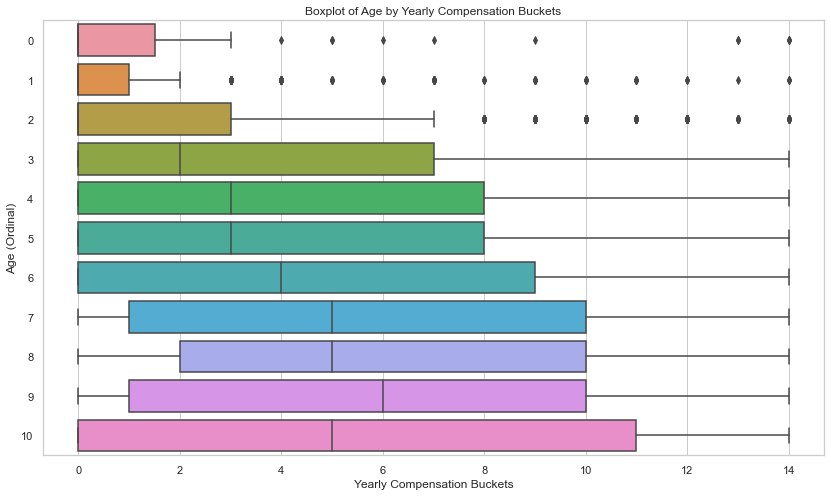

In [2002]:
# Now let's create a box plot of age against yearly compensation
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='Q29', y='Q2', orient='h')
plt.title('Boxplot of Age by Yearly Compensation Buckets')
plt.xlabel('Yearly Compensation Buckets')
plt.ylabel('Age (Ordinal)')
# Adjust y-tick labels to show the age ranges instead of ordinal numbers
#plt.yticks(ticks=range(len(age_mapping)), labels=data['Q2'])
plt.show()

In [2003]:
# Check the unique values in 'Q29' to ensure they are all numeric and there are no strings or 'unknown' entries
unique_y_values = data['Q29'].unique()

unique_y_values

# Convert 'y' to a numeric type explicitly
y_numeric = pd.to_numeric(data['Q29'], errors='coerce')

# Check again for NaN values and unique values after conversion
y_numeric_issues = {
    'NaN_values': y_numeric.isnull().sum(),
    'Unique_values': y_numeric.unique()
}

y_numeric_issues


{'NaN_values': 0,
 'Unique_values': array([ 2., 10., 13., 12.,  9.,  3.,  0.,  5., 11.,  1.,  8., 14.,  7.,
         6.,  4.])}

In [2004]:
# Drop the 'Q26_Corrected' column from the dataset, since we have already encoded the 'Q26' column
data = data.drop(['Q26_Corrected'], axis=1, errors='ignore')

# Separate the target variable and features
X = data.drop(columns=['Q29', 'Q29_buckets'])  # Features
y = data['Q29']  # Target variable

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the Random Forest Classifier to the data
rf_clf.fit(X, y)

# Create a SelectFromModel object that will select features with importance greater than the mean importance
selector = SelectFromModel(rf_clf, threshold='mean')

# Train selector to get the features importances
selector.fit(X, y)

# Get the features that pass the threshold
selected_features = X.columns[(selector.get_support())]

# Number of selected features and the list of selected features
num_selected_features = len(selected_features)
selected_features_list = selected_features.tolist()

num_selected_features, selected_features_list


(47,
 ['Duration (in seconds)',
  'Q2',
  'Q3',
  'Q8',
  'Q9',
  'Q11',
  'Q16',
  'Q25',
  'Q26',
  'Q27',
  'Q30',
  'Q43',
  'Q22_  TensorFlow Hub ',
  'Q22_ Huggingface Models ',
  'Q22_ Kaggle datasets ',
  'Q22_ PyTorch Hub ',
  'Q22_Unknown',
  'Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)',
  'Q23_Data Engineer',
  'Q23_Data Scientist',
  'Q23_Engineer (non-software)',
  'Q23_Machine Learning/ MLops Engineer',
  'Q23_Manager (Program, Project, Operations, Executive-level, etc)',
  'Q23_Other',
  'Q23_Research Scientist',
  'Q23_Software Engineer',
  'Q23_Teacher / professor',
  'Q24_Academics/Education',
  'Q24_Accounting/Finance',
  'Q24_Broadcasting/Communications',
  'Q24_Computers/Technology',
  'Q24_Energy/Mining',
  'Q24_Government/Public Service',
  'Q24_Insurance/Risk Assessment',
  'Q24_Manufacturing/Fabrication',
  'Q24_Marketing/CRM',
  'Q24_Medical/Pharmaceutical',
  'Q24_Non-profit/Service',
  'Q24_Online Service/Internet-based Services',
 

In [2005]:
# Check for any non-numeric columns in the dataset
non_numeric_columns = X.select_dtypes(include=['object']).columns.tolist()

non_numeric_columns


[]

In [2006]:
# Drop the non-numeric columns from the dataset
data = data.drop([ 'Q29_buckets', 'Q26_Corrected'], axis=1, errors='ignore')
# Assuming 'Q29' is the target and all other columns are features
features = data.drop('Q29', axis=1)
target = data['Q29']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# For numerical targets
y_train.fillna(y_train.mean(), inplace=True)
# For categorical targets
y_train.fillna(y_train.mode()[0], inplace=True)

# Now we will scale the features. Since we have already encoded our categorical variables and filled in missing values,
# we will apply standard scaling to the numerical features to normalize their scale.

# Identify numerical columns (which are not encoded and not the target variable)
numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Initialize 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize the ordinal logistic regression model
# Here, we use Logistic Regression with multi_class='ovr' which is a strategy to fit a binary problem per class
# This is one approach to extending Logistic Regression to multi-class (including ordinal) problems
model = LogisticRegression(multi_class='ovr',solver='lbfgs', max_iter=1000, random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, X_train_scaled[numerical_columns], y_train, cv=kf, scoring='accuracy')

# Calculate the average and variance of the accuracy
cv_scores_mean = cv_scores.mean()
cv_scores_variance = cv_scores.var()

print("Mean",cv_scores_mean)
print("Variance", cv_scores_variance)
print("Accuracy", cv_scores)


Mean 0.37953066288550164
Variance 0.0002191769637778944
Accuracy [0.36866359 0.38709677 0.39938556 0.38095238 0.38402458 0.35791091
 0.3655914  0.40706605 0.36615385 0.37846154]


In [2007]:
# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns.tolist()

# Let's take a closer look at these columns to understand their data
non_numeric_data = data[non_numeric_columns].head(20)

non_numeric_data.transpose()  # Transpose for better readability in the output


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20


In [2008]:

# Define the hyperparameters and their ranges to be tested
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300, 400, 500, 1000, 3000, 5000],
    'class_weight': [None, 'balanced']
}

# Initialize the Logistic Regression model
model = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled[numerical_columns], y_train)

# Get the best parameters and the best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best F1 Score: {best_score}")


Best Parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100}
Best F1 Score: 0.2851970325463581


In [2009]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Train the model with the identified best parameters
optimal_model = LogisticRegression(
    C=0.001,
    max_iter=100,
    class_weight='balanced',
    multi_class='ovr',
    solver='lbfgs',
    random_state=42
)

# Fit the model on the training data
optimal_model.fit(X_train_scaled[numerical_columns], y_train)

# Make predictions on the training set
y_train_pred = optimal_model.predict(X_train_scaled[numerical_columns])

# Make predictions on the test set
# Remember to only use the numerical columns for consistency
y_test_pred = optimal_model.predict(X_test_scaled[numerical_columns])

# Evaluate the performance on the training set
training_accuracy = accuracy_score(y_train, y_train_pred)
training_f1_score = f1_score(y_train, y_train_pred, average='weighted')

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

# Analyze the model fit
print("Training Set Performance:")
print(f"Accuracy: {training_accuracy:.4f}")
print(f"F1 Score: {training_f1_score:.4f}")

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

# Get the classification report for both training and test sets
classification_report_train = classification_report(y_train, y_train_pred)
classification_report_test = classification_report(y_test, y_test_pred)

(classification_report_train, classification_report_test)


Training Set Performance:
Accuracy: 0.3041
F1 Score: 0.2935

Test Set Performance:
Accuracy: 0.3077
F1 Score: 0.2990


('              precision    recall  f1-score   support\n\n         0.0       0.62      0.65      0.63      2437\n         1.0       0.15      0.10      0.12       649\n         2.0       0.08      0.02      0.03       490\n         3.0       0.12      0.06      0.08       368\n         4.0       0.13      0.14      0.13       332\n         5.0       0.10      0.09      0.09       299\n         6.0       0.04      0.04      0.04       255\n         7.0       0.04      0.01      0.02       233\n         8.0       0.05      0.09      0.07       168\n         9.0       0.04      0.07      0.05       163\n        10.0       0.13      0.07      0.09       328\n        11.0       0.08      0.12      0.09       217\n        12.0       0.11      0.21      0.15       268\n        13.0       0.14      0.32      0.19       182\n        14.0       0.05      0.13      0.07       119\n\n    accuracy                           0.30      6508\n   macro avg       0.13      0.14      0.12      6508\nweig

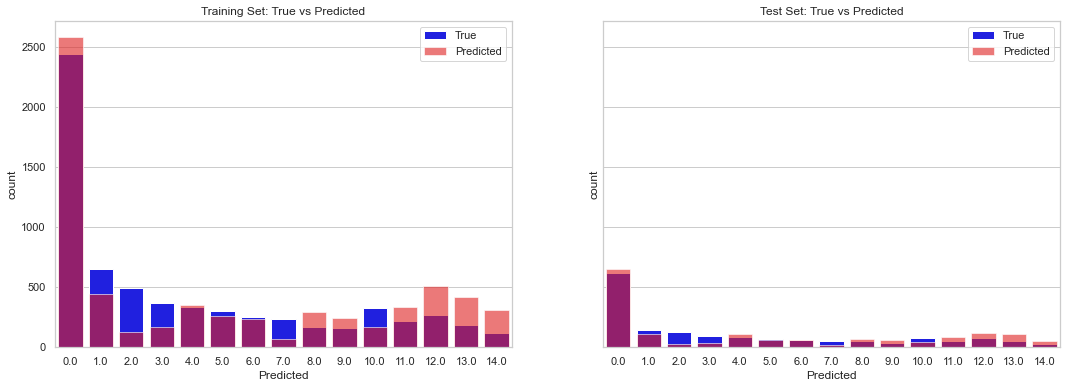

In [2010]:
# plot
# Set up the matplotlib figure
sns.set(style="whitegrid")

# Combine the true and predicted values into a DataFrame for easier plotting
train_results_df = pd.DataFrame({'True': y_train, 'Predicted': y_train_pred})
test_results_df = pd.DataFrame({'True': y_test, 'Predicted': y_test_pred})

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Training set true vs predicted
sns.countplot(x='True', data=train_results_df, ax=axes[0], color='blue', label='True')
sns.countplot(x='Predicted', data=train_results_df, ax=axes[0], color='red', alpha=0.6, label='Predicted')
axes[0].set_title('Training Set: True vs Predicted')
axes[0].legend()

# Test set true vs predicted
sns.countplot(x='True', data=test_results_df, ax=axes[1], color='blue', label='True')
sns.countplot(x='Predicted', data=test_results_df, ax=axes[1], color='red', alpha=0.6, label='Predicted')
axes[1].set_title('Test Set: True vs Predicted')
axes[1].legend()

plt.show()
